In [1]:
# Just a mess of imports. Much more to come.

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import string
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Added the encoding because I was getting an error. Don't know about you.

data = pd.read_csv('data.csv', encoding = "ISO-8859-1")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [5]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
data.iloc[0,0]

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

In [7]:
data[data.isna().any(axis=1)]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [8]:
data['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [9]:
# Simplify

company = {'iPad': 'Apple',
            'Apple': 'Apple',
            'iPad or iPhone App': 'Apple',
            'Google': 'Google',
            'iPhone': 'Apple',
            'Other Google product or service': 'Google',
            'Android App': 'Google',
            'Android': 'Google',
            'Other Apple product or service': 'Apple'}
data['emotion_in_tweet_is_directed_at'] = data['emotion_in_tweet_is_directed_at'].map(company)

In [10]:
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [11]:
print(data['tweet_text'].isna().sum())

data = data[~data['tweet_text'].isna()]

1


In [12]:
# Simplify column names

data.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'brand', 'is_there_an_emotion_directed_at_a_brand_or_product': 'feelings'}, inplace=True)

In [13]:
###################### Simplify for now to create base model. Afterwards, may revisit. #####################

data.drop(data[data['feelings'] == "I can't tell"].index, inplace = True)

In [14]:
# Encode labels

feels = {'Negative emotion': 0,
        'Positive emotion': 1,
        'No emotion toward brand or product': 2}

data['feelings'] = data['feelings'].map(feels)

In [15]:
###################### Simplify for now to create base model. Afterwards, definitely revisit. #####################

data = data[data['feelings'] <= 1]

data.dropna(subset=['brand'], inplace=True)

In [16]:
# Not sure what this accomplishes or why I thought to do this. Creates dataframe with only text and target columns while preserving the company names, but does nothing as an index. Leave for now, figure it out later.

data.set_index('brand', inplace=True)

In [17]:
X = data['text'].map(word_tokenize)
target = data['feelings']

In [18]:
tokenizer = RegexpTokenizer(r'\w+')
hashtag = RegexpTokenizer(r'\#\w+')

In [19]:
data

,text,feelings
brand,,
Apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
Apple,@jessedee Know about @fludapp ? Awesome iPad/i...,1
Apple,@swonderlin Can not wait for #iPad 2 also. The...,1
Apple,@sxsw I hope this year's festival isn't as cra...,0
Google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1
...,...,...
Apple,@mention your PR guy just convinced me to swit...,1
Apple,&quot;papyrus...sort of like the ipad&quot; - ...,1
Google,Diller says Google TV &quot;might be run over ...,0


In [20]:


stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)

In [21]:
stops = stopwords.words('english')
stops += list(string.punctuation)

In [22]:
data['tokens'] = data['text'].apply(tokenizer.tokenize)
data['hash'] = data['text'].apply(hashtag.tokenize)
data

,text,feelings,tokens,hash
brand,,,,
Apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...","[#RISE_Austin, #SXSW]"
Apple,@jessedee Know about @fludapp ? Awesome iPad/i...,1,"[jessedee, Know, about, fludapp, Awesome, iPad...",[#SXSW]
Apple,@swonderlin Can not wait for #iPad 2 also. The...,1,"[swonderlin, Can, not, wait, for, iPad, 2, als...","[#iPad, #SXSW]"
Apple,@sxsw I hope this year's festival isn't as cra...,0,"[sxsw, I, hope, this, year, s, festival, isn, ...",[#sxsw]
Google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",[#SXSW]
...,...,...,...,...
Apple,@mention your PR guy just convinced me to swit...,1,"[mention, your, PR, guy, just, convinced, me, ...","[#sxsw, #princess]"
Apple,&quot;papyrus...sort of like the ipad&quot; - ...,1,"[quot, papyrus, sort, of, like, the, ipad, quo...",[#SXSW]
Google,Diller says Google TV &quot;might be run over ...,0,"[Diller, says, Google, TV, quot, might, be, ru...","[#sxsw, #diller]"


In [23]:
data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word not in stops])
data

,text,feelings,tokens,hash
brand,,,,
Apple,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,"[wesley83, I, 3G, iPhone, After, 3, hrs, tweet...","[#RISE_Austin, #SXSW]"
Apple,@jessedee Know about @fludapp ? Awesome iPad/i...,1,"[jessedee, Know, fludapp, Awesome, iPad, iPhon...",[#SXSW]
Apple,@swonderlin Can not wait for #iPad 2 also. The...,1,"[swonderlin, Can, wait, iPad, 2, also, They, s...","[#iPad, #SXSW]"
Apple,@sxsw I hope this year's festival isn't as cra...,0,"[sxsw, I, hope, year, festival, crashy, year, ...",[#sxsw]
Google,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,"[sxtxstate, great, stuff, Fri, SXSW, Marissa, ...",[#SXSW]
...,...,...,...,...
Apple,@mention your PR guy just convinced me to swit...,1,"[mention, PR, guy, convinced, switch, back, iP...","[#sxsw, #princess]"
Apple,&quot;papyrus...sort of like the ipad&quot; - ...,1,"[quot, papyrus, sort, like, ipad, quot, nice, ...",[#SXSW]
Google,Diller says Google TV &quot;might be run over ...,0,"[Diller, says, Google, TV, quot, might, run, P...","[#sxsw, #diller]"


In [24]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['feelings'])

count_vectorizer = CountVectorizer()

X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

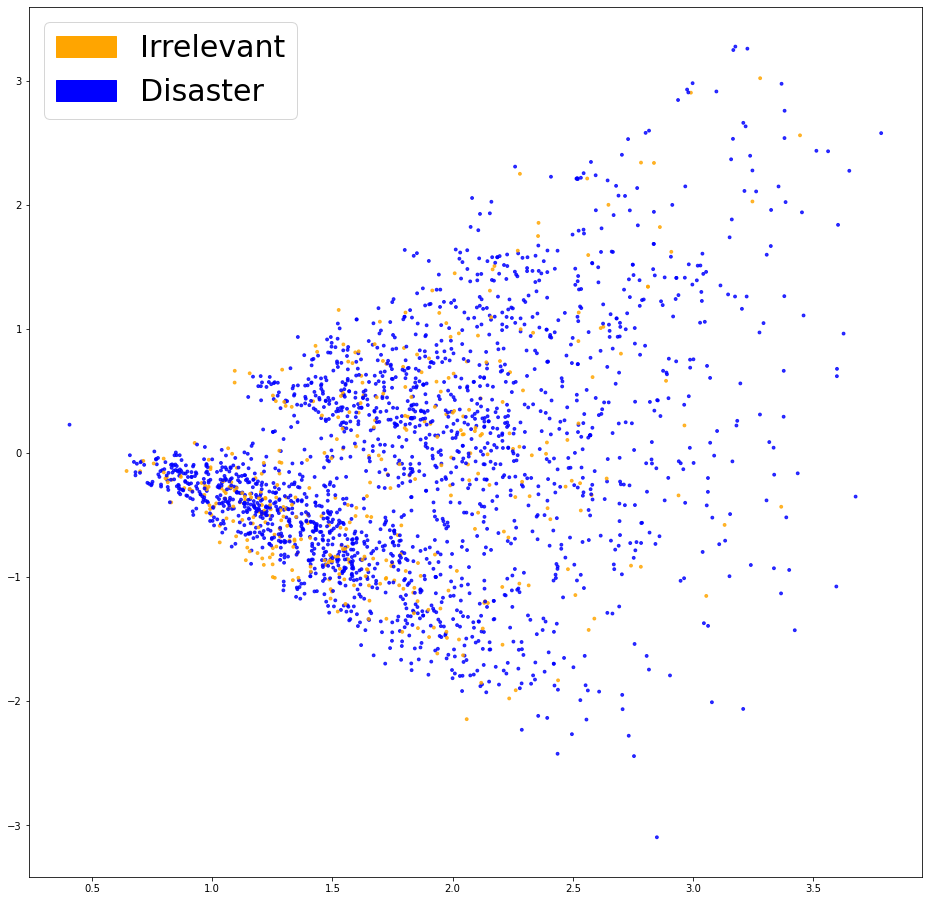

In [25]:
# Straight up stolen code, tweak to needs later or discard because it's useless

from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

In [26]:


clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

In [27]:


def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.870, precision = 0.869, recall = 0.870, f1 = 0.869


In [28]:
confusion_matrix(y_test, y_predicted_counts)

array([[ 73,  53],
       [ 51, 621]], dtype=int64)

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train_counts, y_train)

y_predicted_counts = rf.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.881, precision = 0.892, recall = 0.881, f1 = 0.850


In [30]:
confusion_matrix(y_test, y_predicted_counts)

array([[ 32,  94],
       [  1, 671]], dtype=int64)

In [31]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 35, 40, 41],
    'max_features': [1, 2],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': [40, 45, 50, 55, 60]
}

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_counts, y_train)

y_predicted_counts = grid_search.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)

Fitting 3 folds for each of 320 candidates, totalling 960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    8.8s finished


In [32]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [33]:
grid_search.best_score_

0.8357709413642848

In [34]:
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.842, precision = 0.709, recall = 0.842, f1 = 0.770


In [35]:
nb = MultinomialNB()

In [36]:
nb.fit(X_train_counts, y_train)

y_predicted_counts = nb.predict(X_test_counts)

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.885, precision = 0.880, recall = 0.885, f1 = 0.863
